# Снижение размерности

In [1]:
import os
import pandas as pd

In [2]:
dirnames = ['Фанфик', 'Философия', 'Фэнтези']

In [3]:
curr_dir = os.getcwd()
filepaths = []
for dirname in dirnames:
    filepath = os.path.join(curr_dir, dirname)
    for root, dirs, files in os.walk(filepath):
        for name in files[:150]:
            filepaths.append(os.path.join(root, name))

In [4]:
df = pd.DataFrame(columns=['text', 'filepath', 'genre'])

In [5]:
df['filepath'] = filepaths

In [6]:
for i, row in df.iterrows():
    if 'Философия' in row['filepath']:
        row['genre'] = 'философия'
    elif 'Фанфик' in row['filepath']:
        row['genre'] = 'фанфик'
    else:
        row['genre'] = 'фэнтази'

In [7]:
import nltk
from nltk.corpus import stopwords
from spacy.lang.ru import Russian
from spacy_russian_tokenizer import RussianTokenizer, MERGE_PATTERNS
from pymorphy2 import MorphAnalyzer
import pymorphy2

In [11]:
nlp = Russian()
nlp.max_length = 2500000
russian_tokenizer = RussianTokenizer(nlp, MERGE_PATTERNS)
nlp.add_pipe(russian_tokenizer, name='russian_tokenizer')
morph = pymorphy2.MorphAnalyzer()

def preproc(filename):
    with open(filename, 'r', encoding='utf-8') as f:
        text = f.read()
        # убираем стоп-слова
        text = ' '.join([word for word in text.lower().split() if word not in stopwords.words('russian')])
        # разбиваем на токены
        doc = nlp(text)
        tokenized = [token.text for token in doc if token.text not in ',.!?-();:""«»—_–#' and '.' not in token.text]
        # лемматизируем
        return ' '.join([morph.parse(word)[0].normal_form for word in tokenized])

In [12]:
from tqdm._tqdm_notebook import tqdm_notebook
tqdm_notebook.pandas('PROGRESS>>>')

In [13]:
df['text'] = df['filepath'].progress_apply(preproc)

In [14]:
df.head()

,text,filepath,genre
0,ленточка фанфик роман андрей круз земля лишний...,C:\Users\vital\Фанфик\kowalenko_e_blentochka2.txt,фанфик
1,mass effect while the reaper назвый mass effec...,C:\Users\vital\Фанфик\kowizhenko_w_wmasseffect...,фанфик
2,дмитрий крам s t i k s подкидыш улья андрей пр...,C:\Users\vital\Фанфик\kram_dhivepodkidyshiulxj...,фанфик
3,дмитрий крам исчезнуть клан фанфик играть жить...,C:\Users\vital\Фанфик\kram_discheznuwshijklan.txt,фанфик
4,содержание часть 1 акклиматиазия часть 2 полёт...,C:\Users\vital\Фанфик\krasnoperowa_ahp_peste.txt,фанфик


In [15]:
#df.to_csv('df.csv')

In [81]:
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer

In [111]:
vectorizer = TfidfVectorizer(max_features=25000)

In [112]:
X = vectorizer.fit_transform(df['text'])

In [114]:
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

In [115]:
pca = PCA(n_components=2)

In [116]:
principalComponents = pca.fit_transform(X.todense())
df_pca = pd.DataFrame(data = principalComponents
             , columns = ['principal component 1', 'principal component 2'])

In [117]:
df_final = pd.concat([df_pca, df[['genre']]], axis = 1)

In [118]:
df_final.head()

,principal component 1,principal component 2,genre
0,0.132489,-0.065356,фанфик
1,-0.287312,-0.037368,фанфик
2,0.014455,0.030648,фанфик
3,0.278568,0.027481,фанфик
4,-0.271592,0.019683,фанфик


Визуализация документов на плоскости методом главных компонент снижения размерности Bag-of-Words векторов

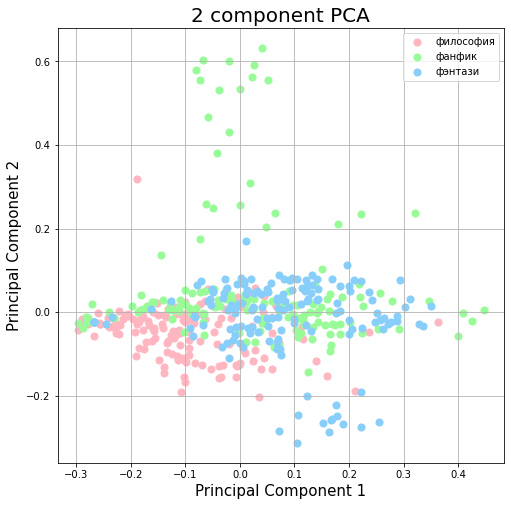

In [119]:
fig = plt.figure(figsize = (8,8))
ax = fig.add_subplot(1,1,1)
ax.set_xlabel('Principal Component 1', fontsize = 15)
ax.set_ylabel('Principal Component 2', fontsize = 15)
ax.set_title('2 component PCA', fontsize = 20)
targets = ['философия', 'фанфик', 'фэнтази']
colors = ['lightpink', 'palegreen', 'lightskyblue']
for target, color in zip(targets,colors):
    indicesToKeep = df_final['genre'] == target
    ax.scatter(df_final.loc[indicesToKeep, 'principal component 1']
               , df_final.loc[indicesToKeep, 'principal component 2']
               , c = color
               , s = 50)
ax.legend(targets)
ax.grid()

Визуализация документов на плоскости методом t-SNE снижения размерности Bag-of-Words векторов.

In [105]:
from sklearn.manifold import TSNE

In [120]:
tsne = TSNE(n_components=2).fit_transform(X.todense())

In [121]:
df_tsne = pd.DataFrame(data = tsne
             , columns = ['principal component 1', 'principal component 2'])

In [122]:
tsne_final = pd.concat([df_tsne, df[['genre']]], axis = 1)

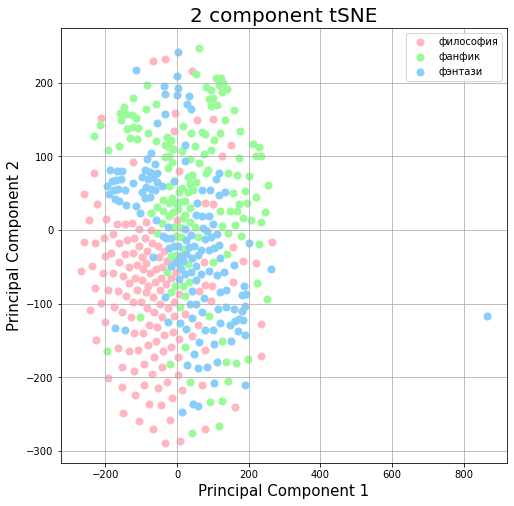

In [123]:
fig = plt.figure(figsize = (8,8))
ax = fig.add_subplot(1,1,1) 
ax.set_xlabel('Principal Component 1', fontsize = 15)
ax.set_ylabel('Principal Component 2', fontsize = 15)
ax.set_title('2 component tSNE', fontsize = 20)
targets = ['философия', 'фанфик', 'фэнтази']
colors = ['lightpink', 'palegreen', 'lightskyblue']
for target, color in zip(targets,colors):
    indicesToKeep = tsne_final['genre'] == target
    ax.scatter(tsne_final.loc[indicesToKeep, 'principal component 1']
               , tsne_final.loc[indicesToKeep, 'principal component 2']
               , c = color
               , s = 50)
ax.legend(targets)
ax.grid()

# Тематическое моделирование

In [124]:
df_emails = pd.read_csv('Emails.csv')

In [125]:
df_emails.head()

,Id,DocNumber,MetadataSubject,MetadataTo,MetadataFrom,SenderPersonId,MetadataDateSent,MetadataDateReleased,MetadataPdfLink,MetadataCaseNumber,...,ExtractedTo,ExtractedFrom,ExtractedCc,ExtractedDateSent,ExtractedCaseNumber,ExtractedDocNumber,ExtractedDateReleased,ExtractedReleaseInPartOrFull,ExtractedBodyText,RawText
0,1,C05739545,WOW,H,"Sullivan, Jacob J",87.0,2012-09-12T04:00:00+00:00,2015-05-22T04:00:00+00:00,DOCUMENTS/HRC_Email_1_296/HRCH2/DOC_0C05739545...,F-2015-04841,...,NaN,"Sullivan, Jacob J <Sullivan11@state.gov>",NaN,"Wednesday, September 12, 2012 10:16 AM",F-2015-04841,C05739545,05/13/2015,RELEASE IN FULL,NaN,UNCLASSIFIED\nU.S. Department of State\nCase N...
1,2,C05739546,H: LATEST: HOW SYRIA IS AIDING QADDAFI AND MOR...,H,NaN,NaN,2011-03-03T05:00:00+00:00,2015-05-22T04:00:00+00:00,DOCUMENTS/HRC_Email_1_296/HRCH1/DOC_0C05739546...,F-2015-04841,...,NaN,NaN,NaN,NaN,F-2015-04841,C05739546,05/13/2015,RELEASE IN PART,"B6\nThursday, March 3, 2011 9:45 PM\nH: Latest...",UNCLASSIFIED\nU.S. Department of State\nCase N...
2,3,C05739547,CHRIS STEVENS,;H,"Mills, Cheryl D",32.0,2012-09-12T04:00:00+00:00,2015-05-22T04:00:00+00:00,DOCUMENTS/HRC_Email_1_296/HRCH2/DOC_0C05739547...,F-2015-04841,...,B6,"Mills, Cheryl D <MillsCD@state.gov>","Abedin, Huma","Wednesday, September 12, 2012 11:52 AM",F-2015-04841,C05739547,05/14/2015,RELEASE IN PART,Thx,UNCLASSIFIED\nU.S. Department of State\nCase N...
3,4,C05739550,CAIRO CONDEMNATION - FINAL,H,"Mills, Cheryl D",32.0,2012-09-12T04:00:00+00:00,2015-05-22T04:00:00+00:00,DOCUMENTS/HRC_Email_1_296/HRCH2/DOC_0C05739550...,F-2015-04841,...,NaN,"Mills, Cheryl D <MillsCD@state.gov>","Mitchell, Andrew B","Wednesday, September 12,2012 12:44 PM",F-2015-04841,C05739550,05/13/2015,RELEASE IN PART,NaN,UNCLASSIFIED\nU.S. Department of State\nCase N...
4,5,C05739554,H: LATEST: HOW SYRIA IS AIDING QADDAFI AND MOR...,"Abedin, Huma",H,80.0,2011-03-11T05:00:00+00:00,2015-05-22T04:00:00+00:00,DOCUMENTS/HRC_Email_1_296/HRCH1/DOC_0C05739554...,F-2015-04841,...,NaN,NaN,NaN,NaN,F-2015-04841,C05739554,05/13/2015,RELEASE IN PART,"H <hrod17@clintonemail.com>\nFriday, March 11,...",B6\nUNCLASSIFIED\nU.S. Department of State\nCa...


In [137]:
from nltk.stem import WordNetLemmatizer
from string import punctuation
import string
import re

In [134]:
def preproc_eng(text):
    text = str(text)
    lemmatizer = WordNetLemmatizer()
    clean_text = ' '.join([word for word in text.lower().split()])
    # убираем знаки препинания
    clean_text = clean_text.translate(str.maketrans(dict.fromkeys(string.punctuation))).split()
    clean_text = [re.sub('[«|»|…]', '', word) for word in clean_text]
    clean_text = [re.sub('\d', '', word) for word in clean_text]
    # лемматизируем
    clean_text = ' '.join([lemmatizer.lemmatize(word) for word in clean_text])
    clean_text = clean_text.replace('\n', '')
    clean_text = clean_text.replace('nan', '')
    # убираем стоп-слова
    clean_text = ' '.join([word for word in clean_text.split() if word not in stopwords.words('english') and len(word) > 2])
    return clean_text

In [135]:
#from tqdm._tqdm_notebook import tqdm_notebook
#tqdm_notebook.pandas('PROGRESS>>>')

In [138]:
emails_corpus = df_emails['ExtractedBodyText'].progress_apply(preproc_eng)

**Для CountVectorizer**

In [139]:
vec = CountVectorizer()
X = vec.fit_transform(emails_corpus)
vocab = vec.get_feature_names()

In [140]:
import gensim
from gensim import matutils
from gensim.models.ldamodel import LdaModel
from scipy.sparse import csc

In [141]:
vocab_dict = dict([(i, s) for i, s in enumerate(vocab)])

In [142]:
corpus = gensim.matutils.Sparse2Corpus(csc.csc_matrix(X))
dictionary = gensim.corpora.Dictionary.from_corpus(corpus, vocab_dict)

In [143]:
lda = LdaModel(matutils.Sparse2Corpus(X.T), num_topics=5, passes=20, id2word=vocab_dict)

In [144]:
topics = lda.print_topics(num_topics=-1, num_words=10)
for topic in topics:
    print(topic)

(0, '0.023*"call" + 0.010*"tomorrow" + 0.010*"get" + 0.009*"see" + 0.009*"know" + 0.008*"want" + 0.008*"email" + 0.008*"today" + 0.007*"also" + 0.006*"back"')
(1, '0.015*"secretary" + 0.015*"office" + 0.010*"house" + 0.008*"obama" + 0.008*"republican" + 0.008*"president" + 0.008*"meeting" + 0.008*"state" + 0.007*"room" + 0.007*"time"')
(2, '0.007*"state" + 0.007*"would" + 0.005*"one" + 0.004*"said" + 0.004*"people" + 0.004*"year" + 0.004*"also" + 0.004*"government" + 0.004*"new" + 0.004*"woman"')
(3, '0.031*"fyi" + 0.017*"state" + 0.013*"cheryl" + 0.013*"huma" + 0.010*"mill" + 0.009*"benghazi" + 0.009*"abedin" + 0.008*"doc" + 0.008*"hrodclintonemailcom" + 0.008*"print"')
(4, '0.009*"israel" + 0.006*"israeli" + 0.006*"party" + 0.006*"american" + 0.004*"palestinian" + 0.004*"koch" + 0.004*"group" + 0.003*"political" + 0.003*"right" + 0.003*"obama"')


In [147]:
from pyLDAvis import gensim
import pyLDAvis

In [148]:
pyLDAvis.enable_notebook()

In [149]:
vis = pyLDAvis.gensim.prepare(lda, corpus, dictionary)
vis

C:\Users\vital\anaconda3\lib\site-packages\pyLDAvis\_prepare.py:257: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  return pd.concat([default_term_info] + list(topic_dfs))


PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
4     -0.154378 -0.074694       1        1  32.896893
2     -0.105616  0.069454       2        1  31.315023
1     -0.096403 -0.099823       3        1  19.073400
3      0.267061 -0.130565       4        1  10.007105
0      0.089335  0.235628       5        1   6.707572, topic_info=      Category         Freq       Term        Total  loglift  logprob
9346   Default  1028.000000        fyi  1028.000000  30.0000  30.0000
3323   Default   707.000000       call   707.000000  29.0000  29.0000
22469  Default  1811.000000      state  1811.000000  28.0000  28.0000
21025  Default  1284.000000  secretary  1284.000000  27.0000  27.0000
16425  Default  1027.000000     office  1027.000000  26.0000  26.0000
...        ...          ...        ...          ...      ...      ...
23843   Topic5   125.496475       time  1107.656006   0.5242  -5.1387
26349   Topic5   120.403839      would  1151.549927   0.4439  -5.1801
13648   Topic5    93.215698       like   681.951111   0.7119  -5.4360
17821   Topic5    76.297333        pls   238.877533   1.5606  -5.6363
16425   Topic5    76.416527     office  1027.009521   0.1037  -5.6348

[364 rows x 6 columns], token_table=       Topic      Freq             Term
term                                   
42         4  0.997686           abedin
45         4  0.997069  abedinhstategov
250        1  0.889403         activist
250        2  0.036451         activist
250        3  0.072902         activist
...      ...       ...              ...
26606      3  0.028315              yes
26606      4  0.090608              yes
26606      5  0.685222              yes
26751      1  0.978839          zionism
26752      1  0.992581          zionist

[659 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[5, 3, 2, 4, 1])

**Для TfIdf Vectorizer**

In [150]:
tfidf = TfidfVectorizer()
X = tfidf.fit_transform(emails_corpus)
vocab = vec.get_feature_names()

In [151]:
vocab_dict = dict([(i, s) for i, s in enumerate(vocab)])

In [152]:
corpus = gensim.matutils.Sparse2Corpus(csc.csc_matrix(X))
dictionary = gensim.corpora.Dictionary.from_corpus(corpus, vocab_dict)

AttributeError: module 'pyLDAvis.gensim' has no attribute 'matutils'

In [ ]:
lda_tfidf = LdaModel(matutils.Sparse2Corpus(X.T), num_topics=5, passes=20, id2word=vocab_dict)

In [ ]:
topics = lda_tfidf.print_topics(num_topics=-1, num_words=10)
for topic in topics:
    print(topic)

In [ ]:
vis = pyLDAvis.gensim.prepare(lda_tfidf, corpus, dictionary)
vis